In [1]:
import pandas as pd
import geopandas as gpd
import osmnx as ox
import networkx as nx
from src.civicsim.router.osmx_router import OSMX_Router
from shapely.geometry import Point, LineString
import matplotlib.pyplot as plt
import dateparser
import csv
import datetime as dt
from src.civicsim.interface.event import Event
from src.civicsim.interface.vehicle import ExpressBus
from gtfs_functions import Feed
import src.civicsim.common.constants as constants

In [3]:
gtfs_path = './data/BOC_gtfs/boc_gtfs.zip'

feed = Feed(gtfs_path, busiest_date=False)
feed.stops

INFO:root:Reading "stops.txt".


,stop_id,stop_name,stop_lat,stop_lon,geometry
0,1000,Chester Terminal,35.415924,-88.663094,POINT (-88.66309 35.41592)
1,1001,TCAT,35.391283,-89.419535,POINT (-89.41953 35.39128)
2,1002,SKI,35.397264,-89.420441,POINT (-89.42044 35.39726)
3,1003,FORD,35.417122,-89.436200,POINT (-89.43620 35.41712)
4,2000,Crockett Terminal,35.791469,-89.113689,POINT (-89.11369 35.79147)
5,2001,TCAT,35.391283,-89.419535,POINT (-89.41953 35.39128)
6,2002,SKI,35.397264,-89.420441,POINT (-89.42044 35.39726)
7,2003,FORD,35.417122,-89.436200,POINT (-89.43620 35.41712)
8,3000,Dyer Terminal,36.043815,-89.343115,POINT (-89.34311 36.04381)
9,3001,TCAT,35.391283,-89.419535,POINT (-89.41953 35.39128)


In [4]:
## Potential groups for analysis:
acs_groups = {"age_sex_educational_attainment": "B15001",
              "age_sex": "B01001",
              "estimated_yearly_income": "B25121"
              }
desired_var_group = acs_groups["age_sex"] # Age
STATEFP = '47' # TN

# 11 counties around BOC
# https://www.census.gov/library/reference/code-lists/ansi.html

COUNTY_FPS_MAP = {"DYER":"045",
                  "GIBSON":"053",
                  "CROCKETT": "033",
                  "LAUDERDALE": "097",
                  "TIPTON": "167",
                  "FAYETTE":"047",
                  "SHELBY":"157",
                  "HARDEMAN":"069",
                  "CHESTER":"023",
                  "MADISON":"113",
                  "HAYWOOD":"075"
                  }
FPS_COUNTY_MAP = {v: k for k, v in COUNTY_FPS_MAP.items()}
# COUNTYFPS = ['097', '075', '023', '069', '157', '167', '033', '113', '045', '053', '047']
COUNTYFPS = [COUNTY_FPS_MAP[k] for k in COUNTY_FPS_MAP.keys()]
BOC_TOTAL_POPULATION = 10_000

ACS5 = "https://api.census.gov/data/2022/acs/acs5"

In [5]:
target_G = ox.load_graphml("./data/target_area.graphml")

### Terminals

In [6]:
boc_gpd = gpd.read_file("./data/BOC.geojson")
boc_offices = ['TCAT', 'SKI', 'FORD', 'OTHER']
office_probs = [0.20, 0.30, 0.40, 0.10]
boc_gpd['location'] = ['BOC'] + boc_offices
boc_gpd = boc_gpd[1:-1]
boc_gpd

,name,geometry,location
1,visitor center,POINT (-89.41953 35.39128),TCAT
2,performance center,POINT (-89.42044 35.39726),SKI
3,water tower,POINT (-89.43620 35.41712),FORD


In [7]:
hubs = pd.read_csv("./output/basic_transit_hub_request_centroid.csv", index_col=0)
hubs['county'] = hubs['county'].astype('str')
hubs['county'] = hubs['county'].str.zfill(3)
hubs['name'] = hubs['county'].map(FPS_COUNTY_MAP)
hubs

,county,t_lat,t_lon,name
0,023,35.415924,-88.663094,CHESTER
1,033,35.791469,-89.113689,CROCKETT
2,045,36.043815,-89.343115,DYER
3,047,35.196449,-89.410376,FAYETTE
4,053,36.002384,-88.928841,GIBSON
5,069,35.216381,-88.997063,HARDEMAN
6,075,35.550761,-89.309812,HAYWOOD
7,097,35.693071,-89.602870,LAUDERDALE
8,113,35.614763,-88.840938,MADISON
9,157,35.196420,-89.884385,SHELBY


In [8]:
## Creating a stops.txt for GTFS from BOC hub and Terminal hub dataframes

In [9]:
data = [['stop_id', 'stop_name', 'stop_lat', 'stop_lon']]
for k, v in hubs.iterrows():
    stop_id = (k + 1) * 1000
    idx = 0
    terminal_name = f"{v['name'].title()} Terminal"
    t_lat = v['t_lat']
    t_lon = v['t_lon']
    _d = [stop_id, terminal_name, t_lat, t_lon]
    data.append(_d)
    for j, w in boc_gpd.iterrows():
        lat = w['geometry'].y
        lon = w['geometry'].x
        stop_idx = stop_id + j
        stop_name = w['location']
        _d = [stop_idx, stop_name, lat, lon]
        data.append(_d)


# Write the data to a CSV file
with open('./data/BOC_gtfs/stops.txt', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerows(data)

### Default travel times from terminal to BOC entrance.

In [10]:
router = OSMX_Router()
router.set_network(target_G)
madison = Point(-88.840938, 35.614763)
TCAT = Point(-89.41953, 35.39128)
SKI = Point(-89.42044, 35.39726)
FORD = Point(-89.43620, 35.41712)
OTHER = Point(-89.43692, 35.42303)
o = SKI
d = FORD
r = router.get_route(o, d)
gdf_dist = ox.routing.route_to_gdf(target_G, r, weight="length")
gdf_tt = ox.routing.route_to_gdf(target_G, r, weight="travel_time")
dist_m = gdf_dist['length'].sum()
tt_s = gdf_tt['travel_time'].sum()
dist_m, tt_s

(5827.708, 446.6)

### Requests

In [11]:
requests_df = pd.read_csv("./output/employee_demand_basic_pop_models.csv")
# requests_df = gpd.read_file("./output/employee_demand_basic_pop_models.csv")
requests_df

,user_id,building_id,COUNTYFP,shift,h_lat,h_lon,w_lat,w_lon,id,distance_m,travel_time_s
0,329,3191392,23,DAY,35.497957,-88.644775,35.423026,-89.436925,329,107753.850,5049.0
1,330,622584,23,DAY,35.483564,-88.600501,35.397264,-89.420441,330,108321.663,5022.5
2,331,2786226,23,MID,35.502178,-88.653541,35.397264,-89.420441,331,108135.888,5260.2
3,332,1398994,23,MID,35.505214,-88.656729,35.417122,-89.436200,332,108067.990,5256.0
4,333,2845077,23,MID,35.501887,-88.614386,35.391283,-89.419535,333,110694.920,5418.8
...,...,...,...,...,...,...,...,...,...,...,...
9989,8183,1830151,167,DAY,35.410078,-89.531577,35.417122,-89.436200,8183,18946.862,845.8
9990,8184,2959951,167,MID,35.413995,-89.550541,35.397264,-89.420441,8184,21330.361,1028.9
9991,8185,1599926,167,MID,35.473802,-89.601198,35.397264,-89.420441,8185,29367.555,1436.2
9992,8186,105517,167,NITE,35.416171,-89.551532,35.417122,-89.436200,8186,21903.980,1078.3


### Fixed Line Bus Parameters

In [12]:
# should be per terminal/hub
bus_info = {
    "capacity": 50,
    "headway_minutes": 15,
    "number": 5,
    "starting_depots": {"lon": -88.840938, "lat": 35.614763},
    "dwell_time_min": 1,
    "delay_time_min": 0, # should be uncertain or based on traffic.
    "start_trip_time": "06:00:00",
    "end_trip_time": "08:00:00"
}

# Simulation scenario (for the fixed line half of the simulation)
* We assume all users are already at the bus stop before the bus begins their trips.
* Buses leave the stop based on the headway minutes (frequency).
* Buses visit only 5 stops. (terminal and 4 stops inside BOC).
* Buses turn around to pick up passengers again from the hub if there are still some left.
* Constraints for this batch is to be at BOC on or before 8:00 am.

In [13]:
import importlib
import src.civicsim.router.locator as locator
importlib.reload(locator)

<module 'src.civicsim.router.locator' from '/media/vanderbilt/home/jptalusan/git/civic_simulator/src/civicsim/router/locator.py'>

In [14]:
router = OSMX_Router()
router.set_network(target_G)
madison = Point(-88.840938, 35.614763)
TCAT = Point(-89.41953, 35.39128)
SKI = Point(-89.42044, 35.39726)
FORD = Point(-89.43620, 35.41712)
OTHER = Point(-89.43692, 35.42303)
o = madison
d = TCAT
r = router.get_route(o, d)
gdf_dist = ox.routing.route_to_gdf(target_G, r, weight="length")
gdf_tt = ox.routing.route_to_gdf(target_G, r, weight="travel_time")
dist_m = gdf_dist['length'].sum()
tt_s = gdf_tt['travel_time'].sum()
dist_m, tt_s

(84804.273, 3219.5)

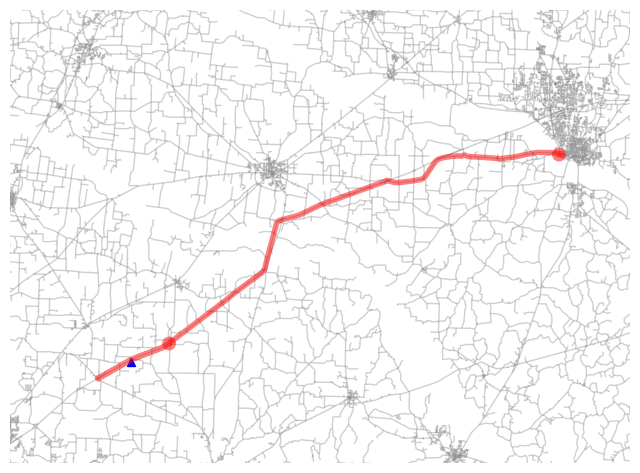

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [15]:
r_linestring = locator.convert_route_to_linestring(target_G, r)
est_point = locator.find_current_location_in_linestring(r_linestring, tt_s, 3000)

bounds = gdf_dist.unary_union.minimum_rotated_rectangle.buffer(0.1).bounds
bounds = (bounds[3], bounds[1], bounds[2], bounds[0])

fig, ax = ox.plot_graph(target_G, node_size=0, bgcolor="white", node_color='k', node_alpha=0.2, node_edgecolor='k', 
                        edge_color='gray', edge_alpha=0.2, show=False, close=False,
                        bbox=bounds)

ax.plot(*est_point.centroid.xy, marker='^', color="blue")
ox.plot_graph_route(target_G, route=r, ax=ax)


In [16]:
stops_df = feed.stops
stops_df['stop_id'] = stops_df['stop_id'].astype('int')
stops_df = stops_df.query("stop_id >= 1000 and stop_id <= 1003")
stops_df

,stop_id,stop_name,stop_lat,stop_lon,geometry
0,1000,Chester Terminal,35.415924,-88.663094,POINT (-88.66309 35.41592)
1,1001,TCAT,35.391283,-89.419535,POINT (-89.41953 35.39128)
2,1002,SKI,35.397264,-89.420441,POINT (-89.42044 35.39726)
3,1003,FORD,35.417122,-89.436200,POINT (-89.43620 35.41712)


In [ ]:
# TODO: Get all counties (adjust stops limit and requests limit)

In [17]:
stops_df = feed.stops
stops_df['stop_id'] = stops_df['stop_id'].astype('int')
stops_df = stops_df.query("stop_id >= 1000 and stop_id <= 1003")

first_row = stops_df.loc[0]
stops_df = pd.concat([stops_df, first_row.to_frame().T], ignore_index=True)

o_d_pairs = list(zip(stops_df.geometry, stops_df.geometry[1:]))
# route_dists, route_times = [router.get_total_dist_and_time(o, d) for (o, d) in o_d_pairs]
route_dists, route_times = [], []
route_strings = []
for o, d in o_d_pairs:
    rd, rt = router.get_total_dist_and_time(o, d)
    r = router.get_route(o, d)
    r_linestring = locator.convert_route_to_linestring(target_G, r)
    route_dists.append(rd)
    route_times.append(rt)
    route_strings.append(r_linestring)

route_dists.append(0)
route_times.append(0)
route_strings.append(None)
stops_df['distance_m'] = route_dists
stops_df['travel_time_s'] = route_times
stops_df['next_stop'] = stops_df['stop_name'].shift(-1)
stops_df['route_ls'] = route_strings
stops_df

,stop_id,stop_name,stop_lat,stop_lon,geometry,distance_m,travel_time_s,next_stop,route_ls
0,1000,Chester Terminal,35.415924,-88.663094,POINT (-88.66309 35.41592),98352.715,4532.9,TCAT,"LINESTRING (-88.6691172 35.4127004, -88.675470..."
1,1001,TCAT,35.391283,-89.419535,POINT (-89.41953 35.39128),786.575,36.9,SKI,"LINESTRING (-89.4144101 35.3905707, -89.411594..."
2,1002,SKI,35.397264,-89.420441,POINT (-89.42044 35.39726),5827.708,446.6,FORD,"LINESTRING (-89.4124876 35.395942, -89.4118238..."
3,1003,FORD,35.417122,-89.4362,POINT (-89.43620 35.41712),84445.621,4598.0,Chester Terminal,"LINESTRING (-89.4377992 35.4253497, -89.433849..."
4,1000,Chester Terminal,35.415924,-88.663094,POINT (-88.66309 35.41592),0.000,0.0,None,None


In [23]:
# People at the madison terminal
# Limiting them to an assumed 20% public transit users.
requests_df = pd.read_csv("./output/employee_demand_basic_pop_models.csv")
print(len(requests_df.index))
commuter_count = int(len(requests_df.index) * 0.20)
print(commuter_count)
requests_df = requests_df.sample(commuter_count)
requests_df = requests_df[(requests_df['shift'] == 'DAY')]
requests_df = requests_df[(requests_df['COUNTYFP'] == 23) & \
                          (requests_df['shift'] == 'DAY')]
len(requests_df.user_id.tolist())

9994
1998


1106

In [44]:

current_date = "10/28/2024"
end_time = bus_info["end_trip_time"]

start_time = bus_info["start_trip_time"]
end_time = bus_info["end_trip_time"]
start_time = dateparser.parse(f"{current_date} {start_time}")
end_time = dateparser.parse(f"{current_date} {end_time}")

bus_dwell_time_min = bus_info["dwell_time_min"]

# timer events will add checkpoints every timer_events min.
# I realized we don't need this and can compute this after the fact.
def recreate_events(checkpoints_min=None):
    current_date = "10/28/2024"
    ### Populate pickup and drop off events.
    headway_frequency = bus_info["headway_minutes"]
    headway_frequency = dt.timedelta(minutes=headway_frequency)

    bus_capacity = bus_info["capacity"]
    # bus_count = 4
    bus_count = bus_info["number"]
    start_time = bus_info["start_trip_time"]
    end_time = bus_info["end_trip_time"]


    start_time = dateparser.parse(f"{current_date} {start_time}")
    end_time = dateparser.parse(f"{current_date} {end_time}")


    buses = []
    events = []
    current_time = start_time
    for bus_id in range(bus_count):
        event = Event(event_type=constants.EVENT_PICKUP, time=current_time, 
                    type_specific_information={"bus_id":bus_id, "current_stop": 0})
        events.append(event)
        current_time += headway_frequency

        bus = ExpressBus(capacity=bus_capacity, current_stop=0)
        buses.append(bus)

    if checkpoints_min is not None:
        timer_events = []
        checkpoint_delta = dt.timedelta(minutes=checkpoints_min)
        timer = start_time
        while timer <= end_time:
            event = Event(event_type=constants.EVENT_TIMER, time=timer)
            timer_events.append(event)
            timer += checkpoint_delta
            
        for ne in timer_events:
            events.append(ne)

    events.sort(key=lambda x: (x.time, x.event_type), reverse=False)
    
    return buses, events

### Concerns:
* Buses need to get back to depot

In [45]:
len(requests_df.index)

65

In [46]:
# Dictionary of route strings
# should buses travel when there are no passengers? (it should i think)

In [48]:
buses, events = recreate_events()
people_at_stop = len(requests_df.index)
number_of_stops = len(stops_df.index) - 1
# print(people_at_stop, number_of_stops)
current_time = start_time
# print(current_time, end_time, current_time < end_time)
# [print(e) for e in events]

new_time = None
elapsed_time = 0

people_at_BOC = 0

print(f"people at terminal: {people_at_stop}")
while (current_time < (end_time + dt.timedelta(hours=1))):
    new_events = []
    event = events.pop(0)
    # print(event, event_type)
    event_type = event.event_type
    elapsed_time = event.time - current_time
    # print(f"Elapsed time: {elapsed_time} @ {current_time}")

    current_time = event.time

    if event_type != constants.EVENT_TIMER:
        current_stop = event.type_specific_information['current_stop']
        current_stop = current_stop % number_of_stops
        bus_id = event.type_specific_information['bus_id']
        bus = buses[bus_id]
        bus.current_stop = current_stop

    if event_type == constants.EVENT_PICKUP:
        free_seats = bus.capacity - bus.load
        stop_name = stops_df.iloc[current_stop]['stop_name']
        next_stop = stops_df.iloc[current_stop]['next_stop']

        picked_up = 0
        if 'Chester Terminal' == stop_name and people_at_stop > 0:
            picked_up = min(free_seats, people_at_stop)
            bus.load += picked_up
            people_at_stop -= picked_up

        travel_time_to_next_stop = stops_df.iloc[current_stop]['travel_time_s']
        distance_to_next_stop = stops_df.iloc[current_stop]['distance_m']
        
        time_at_next_stop = current_time + dt.timedelta(seconds=travel_time_to_next_stop)
        new_event = Event(event_type=constants.EVENT_DROPOFF, time=time_at_next_stop, 
                    type_specific_information={"bus_id":bus_id, "current_stop": current_stop + 1})
        new_events.append(new_event)

        if 'Madison Terminal' == stop_name:
            print(f"bus: {bus_id}, pick up {picked_up} people @ {current_time} on {stop_name}")
            # print(f"remaining: {people_at_stop}")

    elif event_type == constants.EVENT_DROPOFF:
        stop_name = stops_df.iloc[current_stop]['stop_name']
        
        new_event = Event(event_type=constants.EVENT_PICKUP, time=current_time, 
                    type_specific_information={"bus_id":bus_id, "current_stop": current_stop})
        new_events.append(new_event)
        if 'TCAT' == stop_name:
            print(f"bus: {bus_id}, drop off {bus.load} people @ {current_time} on {stop_name}")

            people_at_BOC += bus.load
            bus.load = 0

    # print(people_at_stop, people_at_BOC)
    
    for ne in new_events:
        events.append(ne)
    events.sort(key=lambda x: (x.time, x.event_type), reverse=False)

people at terminal: 65
bus: 0, drop off 50 people @ 2024-10-28 07:15:32.900000 on TCAT
bus: 1, drop off 15 people @ 2024-10-28 07:30:32.900000 on TCAT
bus: 2, drop off 0 people @ 2024-10-28 07:45:32.900000 on TCAT
bus: 3, drop off 0 people @ 2024-10-28 08:00:32.900000 on TCAT
bus: 4, drop off 0 people @ 2024-10-28 08:15:32.900000 on TCAT


In [72]:
for b in buses:
    # print(b.id, b.load)
    print(b.load)

0
0
50
17
0


In [37]:
# Unfinished events
[print(e) for e in events]
pass

2024-10-28 09:00:29.800000,EVENT_PICKUP,{'bus_id': 1, 'current_stop': 2}
2024-10-28 09:42:26.800000,EVENT_DROPOFF,{'bus_id': 0, 'current_stop': 4}
